In [ ]:
import numpy as np
import pandas as pd

from sklearn.feature_extraction.text import CountVectorizer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
import re


Using TensorFlow backend.


In [ ]:
from google.colab import files
uploaded = files.upload()

Saving FinancialSentiment.csv to FinancialSentiment.csv


In [ ]:
data = pd.read_csv('FinancialSentiment.csv', 
                   header = None, encoding="ISO-8859-1")
data.columns = ['Label', 'Text']
data.head()

,Label,Text
0,neutral,"According to Gran , the company has no plans t..."
1,neutral,Technopolis plans to develop in stages an area...
2,negative,The international electronic industry company ...
3,positive,With the new production plant the company woul...
4,positive,According to the company 's updated strategy f...


In [ ]:
max_features = 2000
tokenizer = Tokenizer(num_words=max_features, split=' ')
tokenizer.fit_on_texts(data['Text'].values)
X = tokenizer.texts_to_sequences(data['Text'].values)
X = pad_sequences(X)

In [ ]:
embed_dim = 128
lstm_out = 196

model = Sequential()
model.add(Embedding(max_features, embed_dim, input_length = X.shape[1]))
model.add(SpatialDropout1D(0.4))
model.add(LSTM(lstm_out, dropout=0.5, return_sequences=True, recurrent_dropout=0.5))
model.add(LSTM(lstm_out, dropout=0.4, recurrent_dropout=0.4))
model.add(Dense(3,activation='softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics = ['accuracy'])
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 59, 128)           256000    
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 59, 128)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 59, 196)           254800    
_________________________________________________________________
lstm_2 (LSTM)                (None, 196)               308112    
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 591       
Total params: 819,503
Trainable params: 819,503
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
Y = pd.get_dummies(data['Label']).values
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.2, random_state = 42)
X_validate, X_test, Y_validate, Y_test = train_test_split(X_test, Y_test, test_size = 0.5, random_state=1)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)
print(X_validate.shape, Y_validate.shape)

(3876, 46) (3876, 3)
(485, 46) (485, 3)
(485, 46) (485, 3)


In [ ]:
from keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(min_delta = 0.0001, monitor='val_loss', patience = 3, restore_best_weights=True)
callback = [early_stopping]

batch_size = 32
history = model.fit(X_train, Y_train, validation_data=(X_validate, Y_validate), epochs = 5, batch_size=batch_size, verbose = 1, callbacks=callback)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 3876 samples, validate on 485 samples
Epoch 1/5
3876/3876 [==============================] - 39s 10ms/step - loss: 0.8828 - accuracy: 0.6192 - val_loss: 0.7758 - val_accuracy: 0.6619
Epoch 2/5
3876/3876 [==============================] - 38s 10ms/step - loss: 0.7354 - accuracy: 0.6855 - val_loss: 0.7246 - val_accuracy: 0.6701
Epoch 3/5
3876/3876 [==============================] - 39s 10ms/step - loss: 0.6428 - accuracy: 0.7353 - val_loss: 0.6484 - val_accuracy: 0.7320
Epoch 4/5
3876/3876 [==============================] - 38s 10ms/step - loss: 0.5430 - accuracy: 0.7890 - val_loss: 0.5689 - val_accuracy: 0.7918
Epoch 5/5
3876/3876 [==============================] - 38s 10ms/step - loss: 0.4623 - accuracy: 0.8253 - val_loss: 0.5595 - val_accuracy: 0.7856


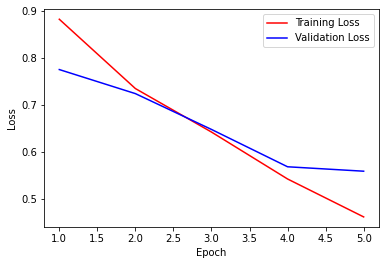

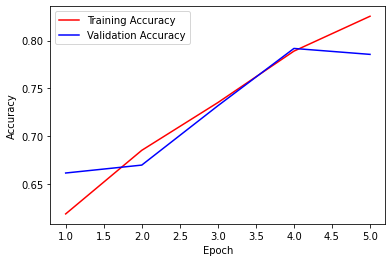

In [ ]:
  import matplotlib.pyplot as plt

epochs = range(1, len(history.history['loss']) + 1)
plt.plot(epochs, history.history['loss'], 'r-')
plt.plot(epochs, history.history['val_loss'], 'b-')
plt.legend(['Training Loss', 'Validation Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

plt.plot(epochs, history.history['accuracy'], 'r-')
plt.plot(epochs, history.history['val_accuracy'], 'b-')
plt.legend(['Training Accuracy', 'Validation Accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

In [ ]:
loss, acc = model.evaluate(X_test, Y_test, verbose=1)
print('Test Accuracy: %f' % (acc*100))

485/485 [==============================] - 1s 3ms/step
Test Accuracy: 73.814434


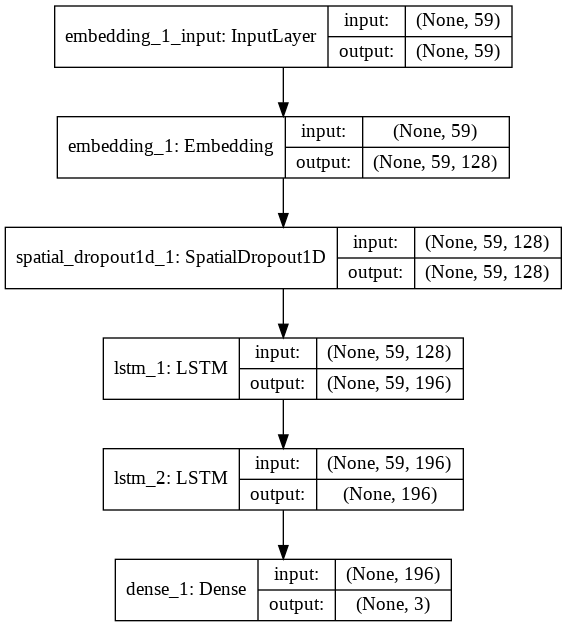

In [ ]:
from keras.utils import plot_model
plot_model(model, to_file='model.png', show_shapes=True)